# 2.3 Available data and its quality
>

In [1]:
library(here)
source(here("setup.R"))
library(zoo)
library(ggmagnify)
library(latex2exp)
library(scales)


here() starts at /Users/stefan/workspace/work/phd/thesis



## RKI case and death data

### `tikz/cases_germany.tex`

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


pdf 
  2

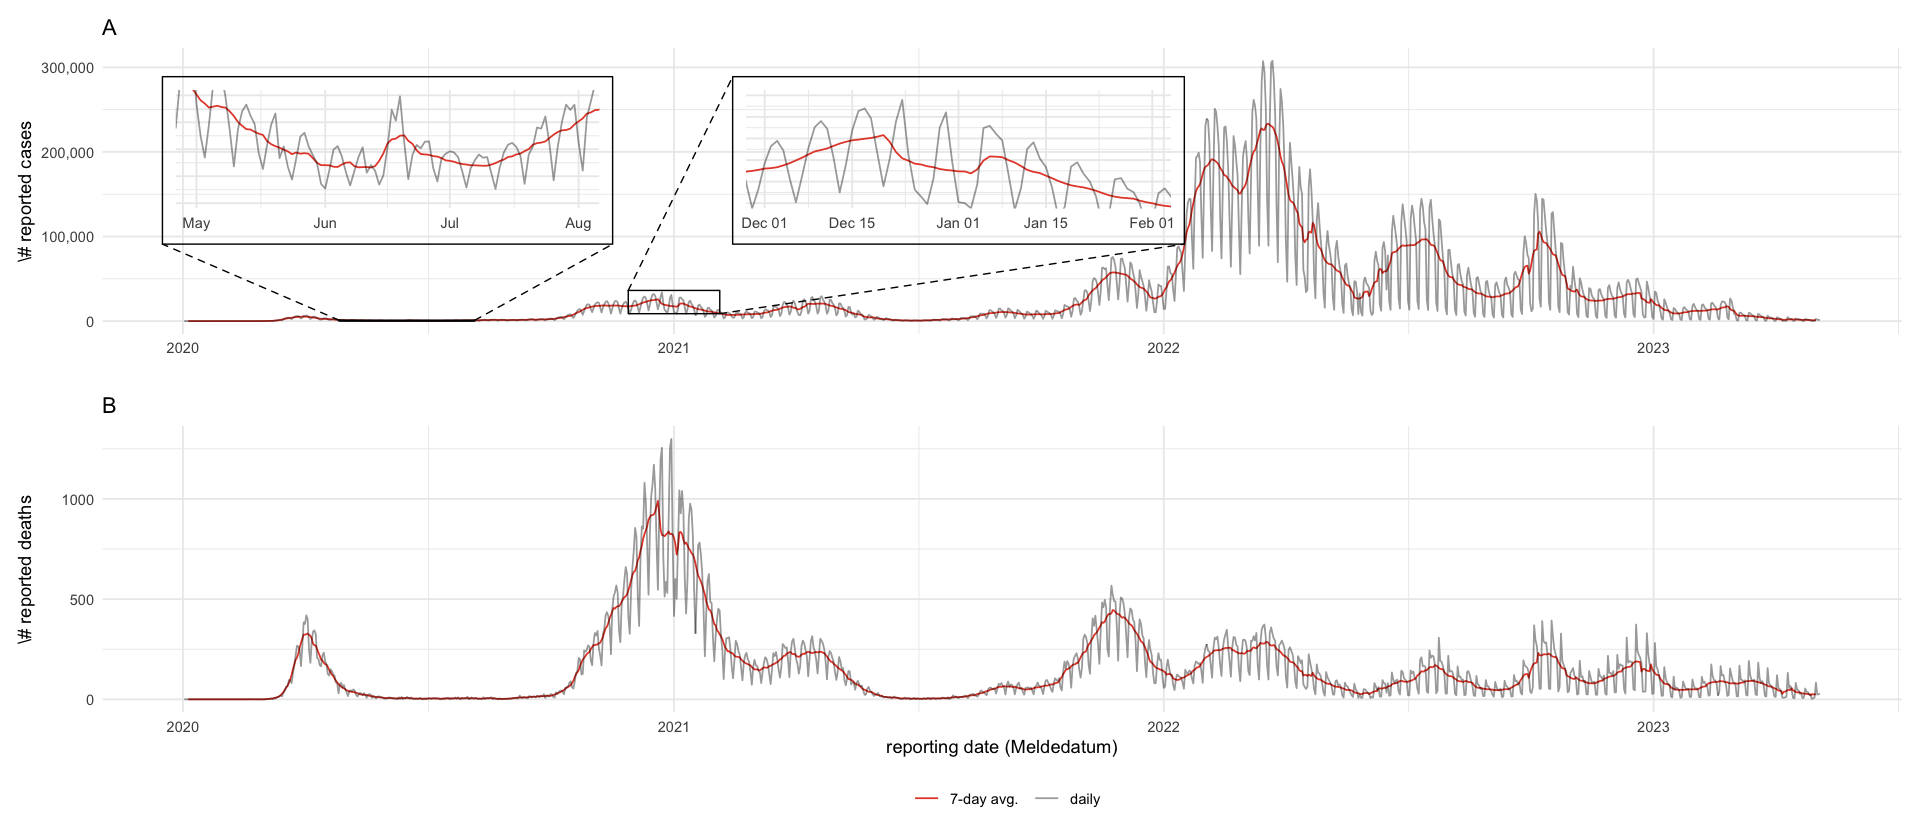

In [2]:
rki_county <- here("data/processed/RKI_county.csv") %>%
    read_csv()

df_weekly <- rki_county %>%
    group_by(date) %>%
    summarize(cases = sum(cases), deaths = sum(deaths)) %>%
    mutate(cases_7 = rollmean(cases, k = 7, fill = NA), deaths_7 = rollmean(deaths, k = 7, fill = NA))

p_cases <- df_weekly %>%
    select(-deaths_7) %>%
    pivot_longer(cols = c(cases, cases_7), names_to = "type", values_to = "value") %>%
    mutate(type = ifelse(type == "cases", "daily", "7-day avg.")) %>%
    ggplot(aes(date, value, color = type, alpha = type)) +
    geom_line() +
    scale_y_continuous(labels = scales::comma) +
    scale_color_manual(values = c("daily" = "black", "7-day avg." = pal_npg()(1))) +
    scale_alpha_manual(values = c("daily" = .4, "7-day avg." = 1)) +
    labs(x = "", y = "\\# reported cases", alpha = "", color = "", title = "A") +
    geom_magnify( # christmas
        from = list(ymd("2020-12-01"), ymd("2021-02-01"), .1 * 1e5, .35 * 1e5),
        to =   list(ymd("2021-03-01"), ymd("2022-01-01"), 1e5, 2.8e5),
        axes = "x"
    ) +
    geom_magnify( # Toennies
        from = list(ymd("2020-05-01"), ymd("2020-08-01"), 0, .1e4),
        to = list(ymd("2020-01-01"), ymd("2020-11-01"), 1e5, 2.8e5),
        axes = "x"
    )

p_deaths <- df_weekly %>%
    select(-cases_7) %>%
    pivot_longer(cols = c(deaths, deaths_7), names_to = "type", values_to = "value") %>%
    mutate(type = ifelse(type == "deaths", "daily", "7-day avg.")) %>%
    ggplot(aes(date, value, color = type, alpha = type)) +
    geom_line() +
    scale_color_manual(values = c("daily" = "black", "7-day avg." = pal_npg()(1))) +
    scale_alpha_manual(values = c("daily" = .4, "7-day avg." = 1)) +
    labs(x = "reporting date (Meldedatum)", y = "\\# reported deaths", alpha = "", color = "", title = "B")
# geom_magnify( # christmas
#    from = list(ymd("2020-11-15"), ymd("2021-02-01"), 600, 1000),
#    to = list(ymd("2021-03-10"), ymd("2021-10-10"), 400, 1100),
#    axes = "x"
# )

(p_cases / p_deaths) + plot_layout(guides = "collect") & theme(legend.position = "bottom", legend.box = "horizontal")
ggsave_tikz(here("tikz/cases_germany.tex"))


### Infection date vs. reporting date

IstErkrankungsbeginn,cases,prop
<dbl>,<dbl>,<dbl>
0,29422629,75.80404
1,9391434,24.19596


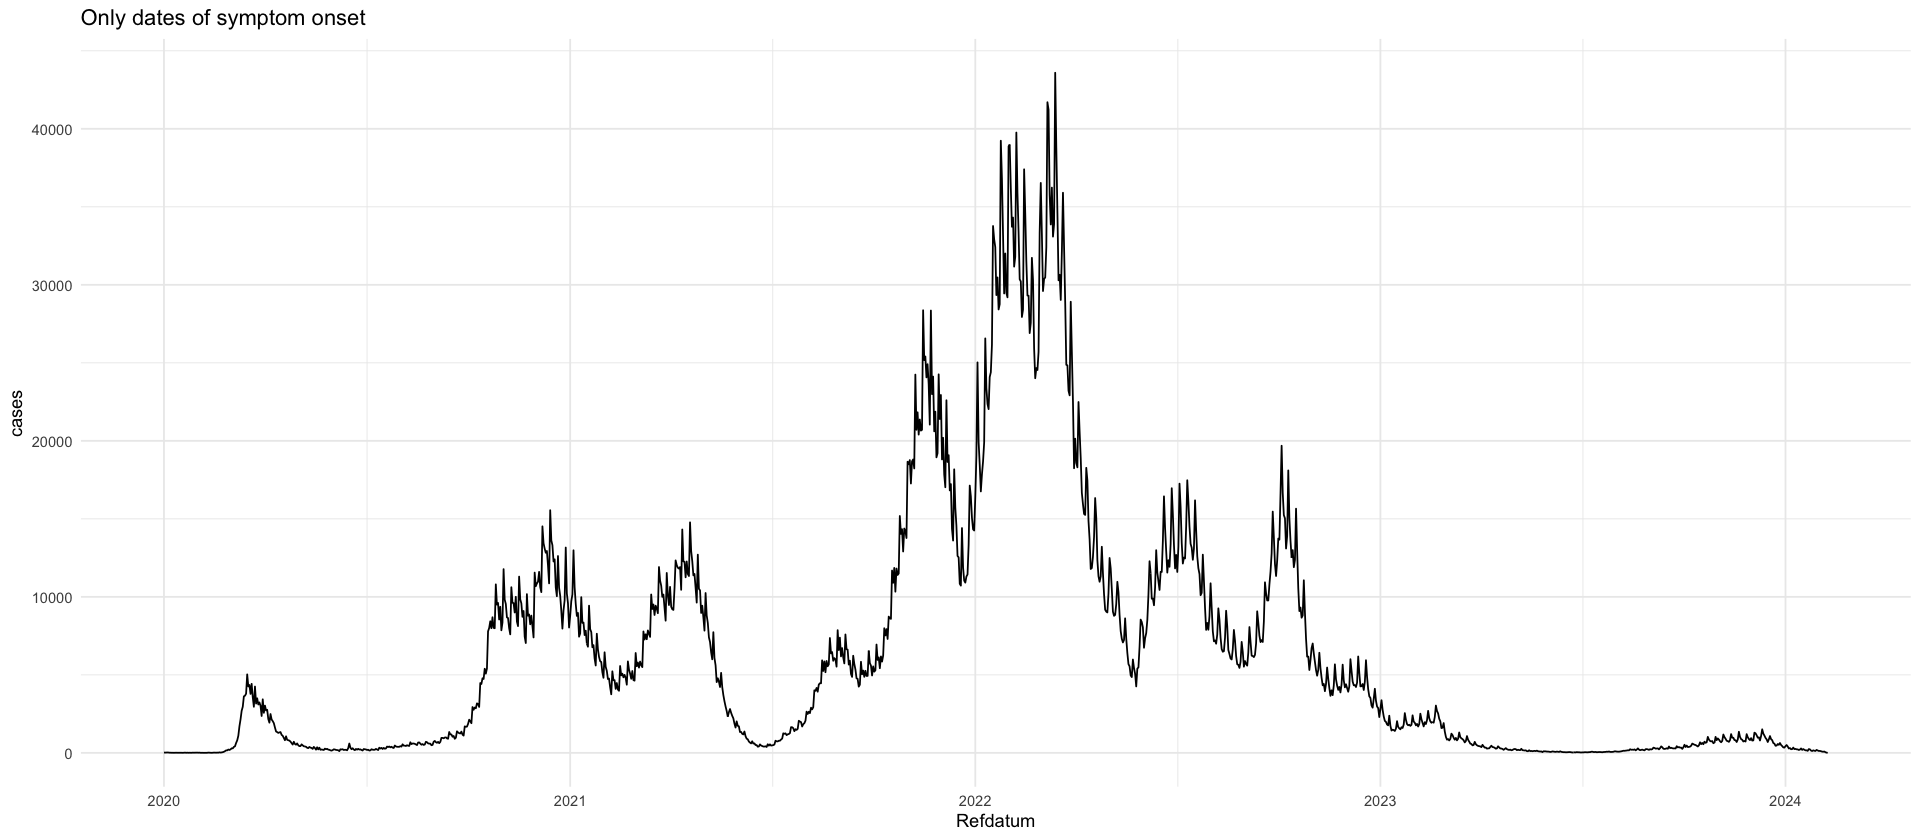

In [3]:
rki_raw <- read_csv(here("data/raw/RKI.csv"))

rki_raw %>%
    group_by(IstErkrankungsbeginn) %>%
    summarize(cases = sum(AnzahlFall * (NeuerFall >= 0))) %>%
    mutate(prop = cases / sum(cases) * 100)

rki_raw %>%
    filter(IstErkrankungsbeginn == 1) %>%
    group_by(Refdatum) %>%
    summarize(cases = sum(AnzahlFall * (NeuerFall >= 0))) %>%
    ggplot(aes(Refdatum, cases)) +
    geom_line() +
    labs(title = "Only dates of symptom onset")


### reporting triangle

We use the reporting triangle for the number of cases, i.e. on any day $t$ the number of cases $$I_{s,t}$$ that are reported associated with date $s < t$. 

We begin our analysis on April 1st 2020, when data have become stable enough to warrant an analysis.

In [4]:
full_rep_tri <- read_csv(here("data/raw/rki_cases_deaths_delays.csv")) %>%
    select(t = rki_date, s = county_date, I = cases) %>%
    filter(s >= ymd("2020-04-01"))


In [5]:
full_rep_tri %>%
    pull(s) %>%
    range()


[1] "2020-04-01" "2023-10-12"

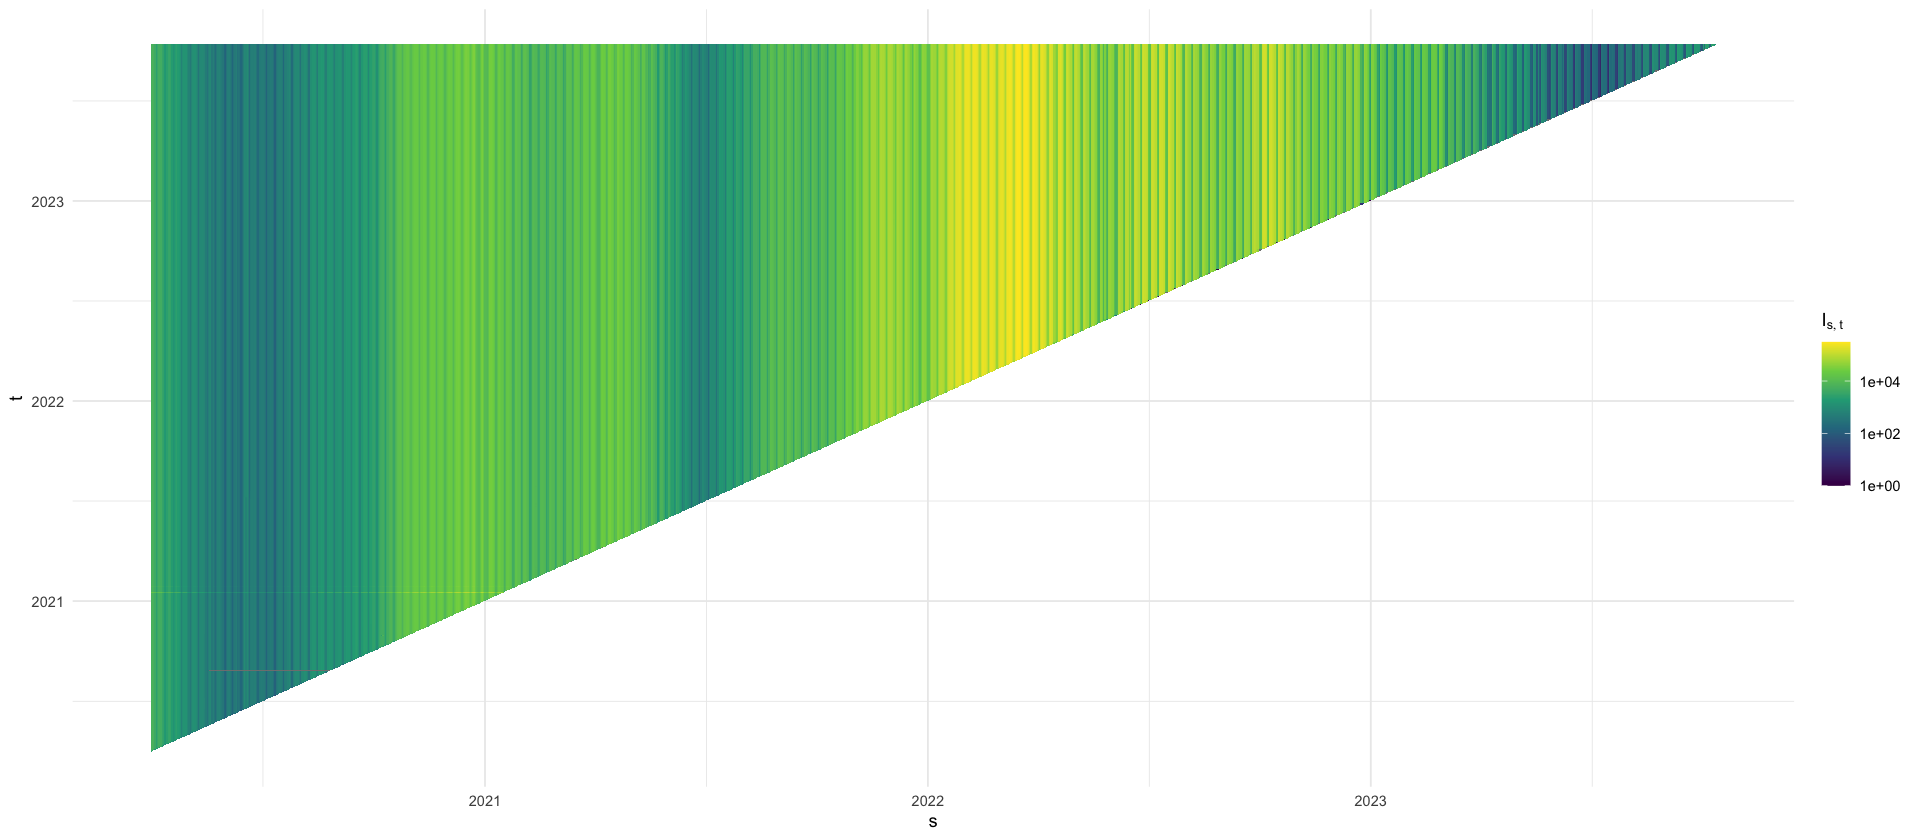

In [6]:
full_rep_tri %>%
    mutate(I = ifelse(I < 1, NA, I)) %>%
    ggplot(aes(x = s, y = t, fill = I)) +
    geom_tile() +
    scale_fill_viridis_c(trans = "log10") +
    labs(x = "s", y = "t", fill = TeX("$I_{s,t}$"))


How often is $I_{s,t} > I_{s,T}$?

q90,q95,q99,q999
<dbl>,<dbl>,<dbl>,<dbl>
0.4065041,0.6497726,1.840491,16.1435


t,s,I,rel_diff,rel_diff_pct
<date>,<date>,<dbl>,<dbl>,<dbl>
2021-01-17,2020-12-24,58712,1.779924,177.9924
2021-01-17,2021-01-03,24542,1.781594,178.1594
2021-01-17,2020-11-30,36988,1.781889,178.1889
2021-01-17,2020-12-31,54618,1.792331,179.2331
2021-01-17,2020-12-21,56628,1.792996,179.2996
2021-01-17,2021-01-02,27996,1.799040,179.9040
2021-01-17,2021-01-10,23721,1.800921,180.0921
2021-01-17,2021-01-04,40161,1.805323,180.5323
2021-01-17,2021-01-05,77088,1.808306,180.8306


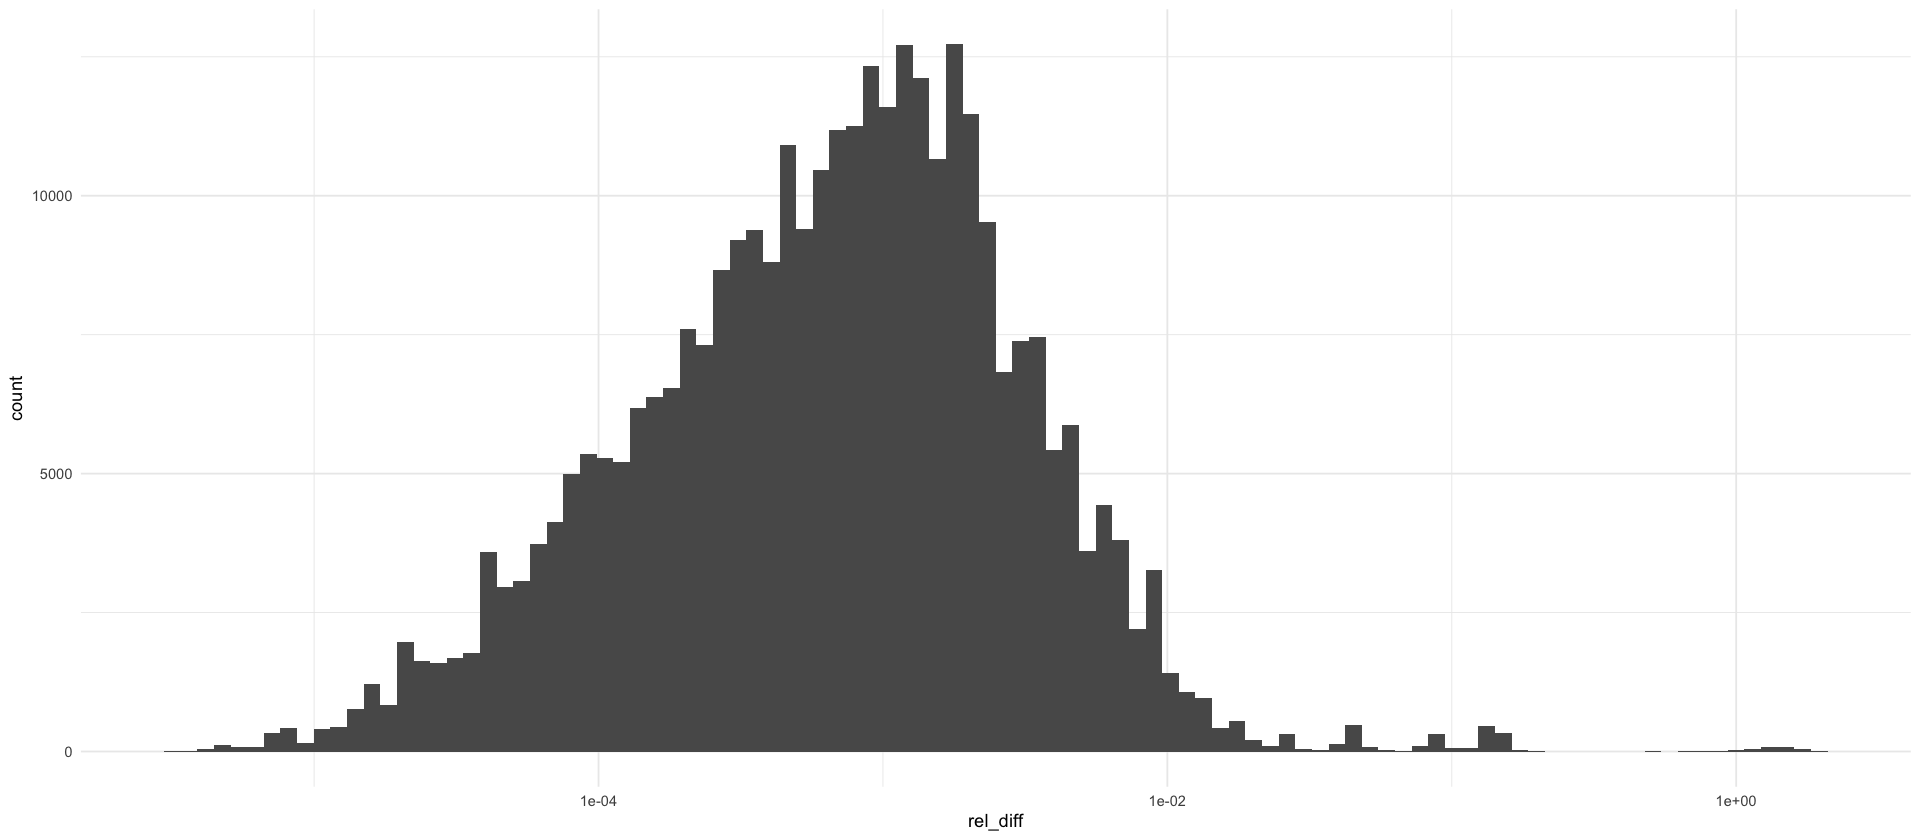

In [7]:
rel_diffs <- full_rep_tri %>%
    group_by(s) %>%
    arrange(t) %>%
    mutate(rel_diff = (I - tail(I, 1)) / tail(I, 1)) %>%
    ungroup() %>%
    filter(rel_diff > 0) %>%
    mutate(rel_diff_pct = rel_diff * 100)

rel_diffs %>%
    ggplot(aes(x = rel_diff)) +
    geom_histogram(bins = 100) +
    scale_x_log10()

rel_diffs %>%
    summarize(
        q90 = quantile(rel_diff_pct, .9),
        q95 = quantile(rel_diff_pct, .95),
        q99 = quantile(rel_diff_pct, .99),
        q999 = quantile(rel_diff_pct, .999)
    )

rel_diffs %>%
    arrange(rel_diff_pct) %>%
    tail(20)


### `tikz/reporting_delays_cases.tex`

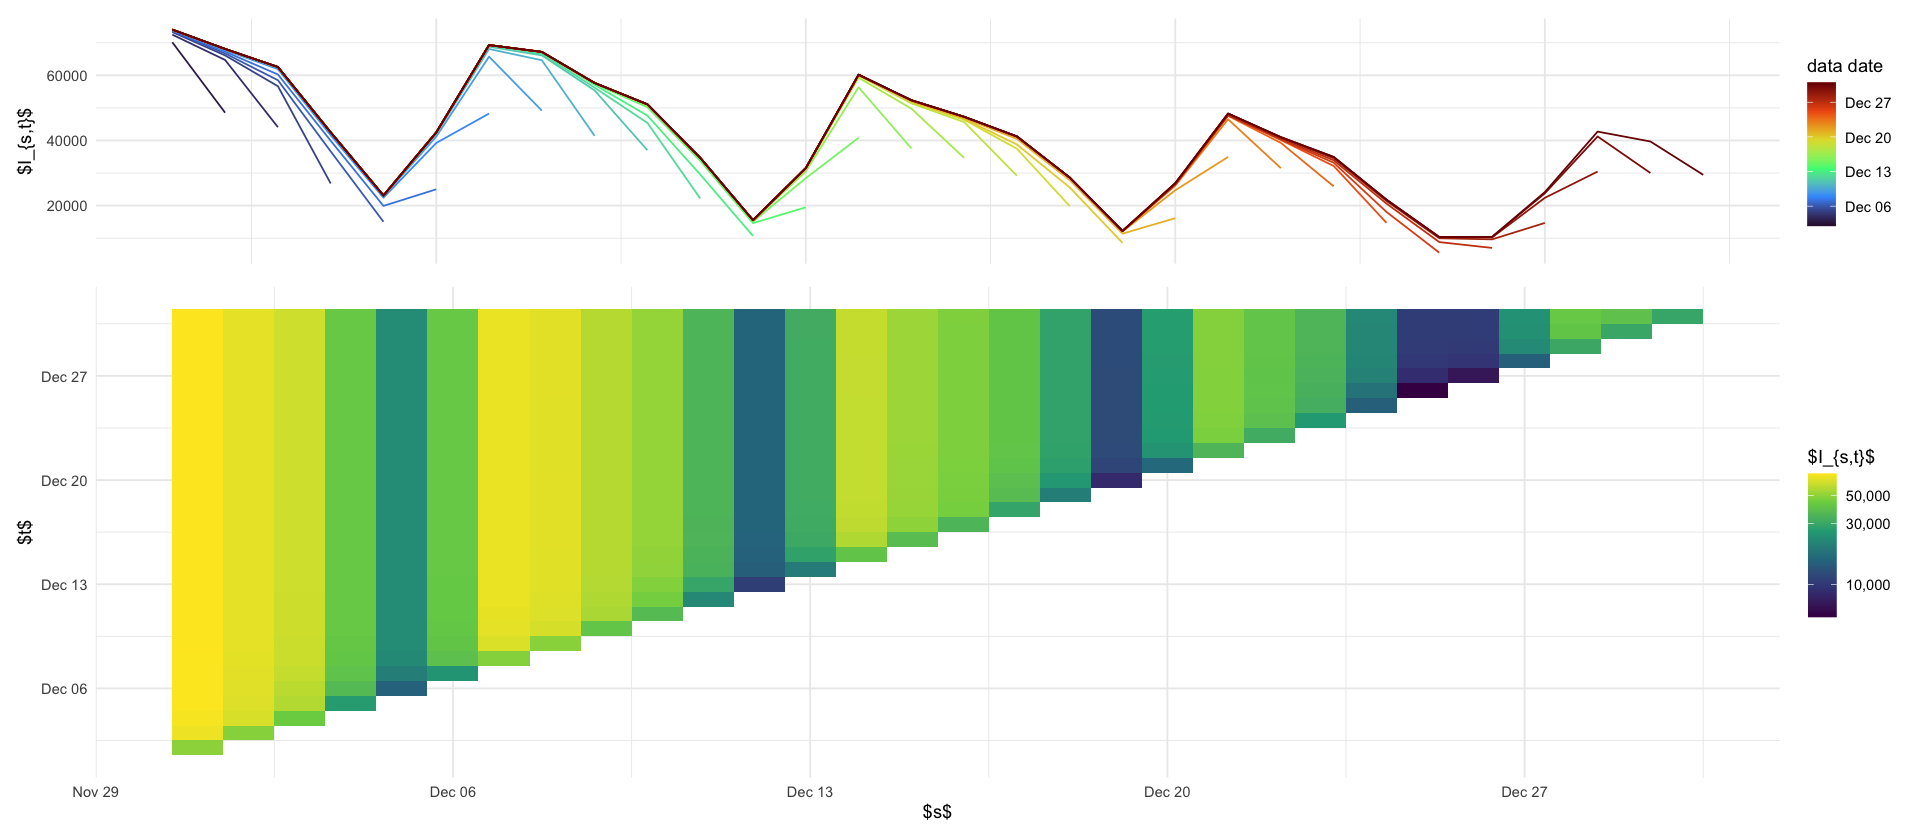

In [8]:
data_april <- full_rep_tri %>%
    filter(s >= ymd("2021-12-01"), s < ymd("2022-01-01")) %>%
    filter(t >= ymd("2021-12-01"), t < ymd("2022-01-01"))
p_reptri_case <- data_april %>%
    ggplot(aes(x = s, y = t, fill = I)) +
    geom_tile() +
    scale_fill_viridis_c(trans = "log10", labels = label_comma()) +
    labs(x = "$s$", y = "$t$", fill = "$I_{s,t}$")

p_maginal_case <- data_april %>%
    ggplot(aes(x = s, y = I, color = t, group = factor(t))) +
    geom_line() +
    theme(axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank()) +
    labs(x = "", y = "$I_{s,t}$", color = "data date") +
    scale_color_viridis_c(option = "H", trans = "date")

(p_maginal_case / p_reptri_case) + plot_layout(heights = c(1, 2))


## `data/processed/RKI_4day_rt.csv`

We are only interested in the number of _newly_ reported cases on each day. Let 
$$
    I_{s,t} = \sum_{\tau = 0}^{t - s} i_{s, \tau}
$$
be the distribution of reported on date $t$ for date $s$. We will assume that $i_{s,\tau} \geq 0$ always holds. To ensure this, let $T$ be the last date observed and set 
$$
    \tilde I_{s,t} = \min \{\max \{I_{s,s}, \dots, I_{s,t}\}, I_{s,T}\}.
$$
$\tilde I_{s,t}$ is a running maximum that is cut-off at the final value $I_{s,T}$ (to deal with big rearrangements of cases, due to missingness or faulty data).

Warning message in scale_fill_viridis_c(trans = "log10", na.value = rgb(0, 0, 0, :
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 795691 rows containing missing values or values outside the scale range
(`geom_tile()`).”


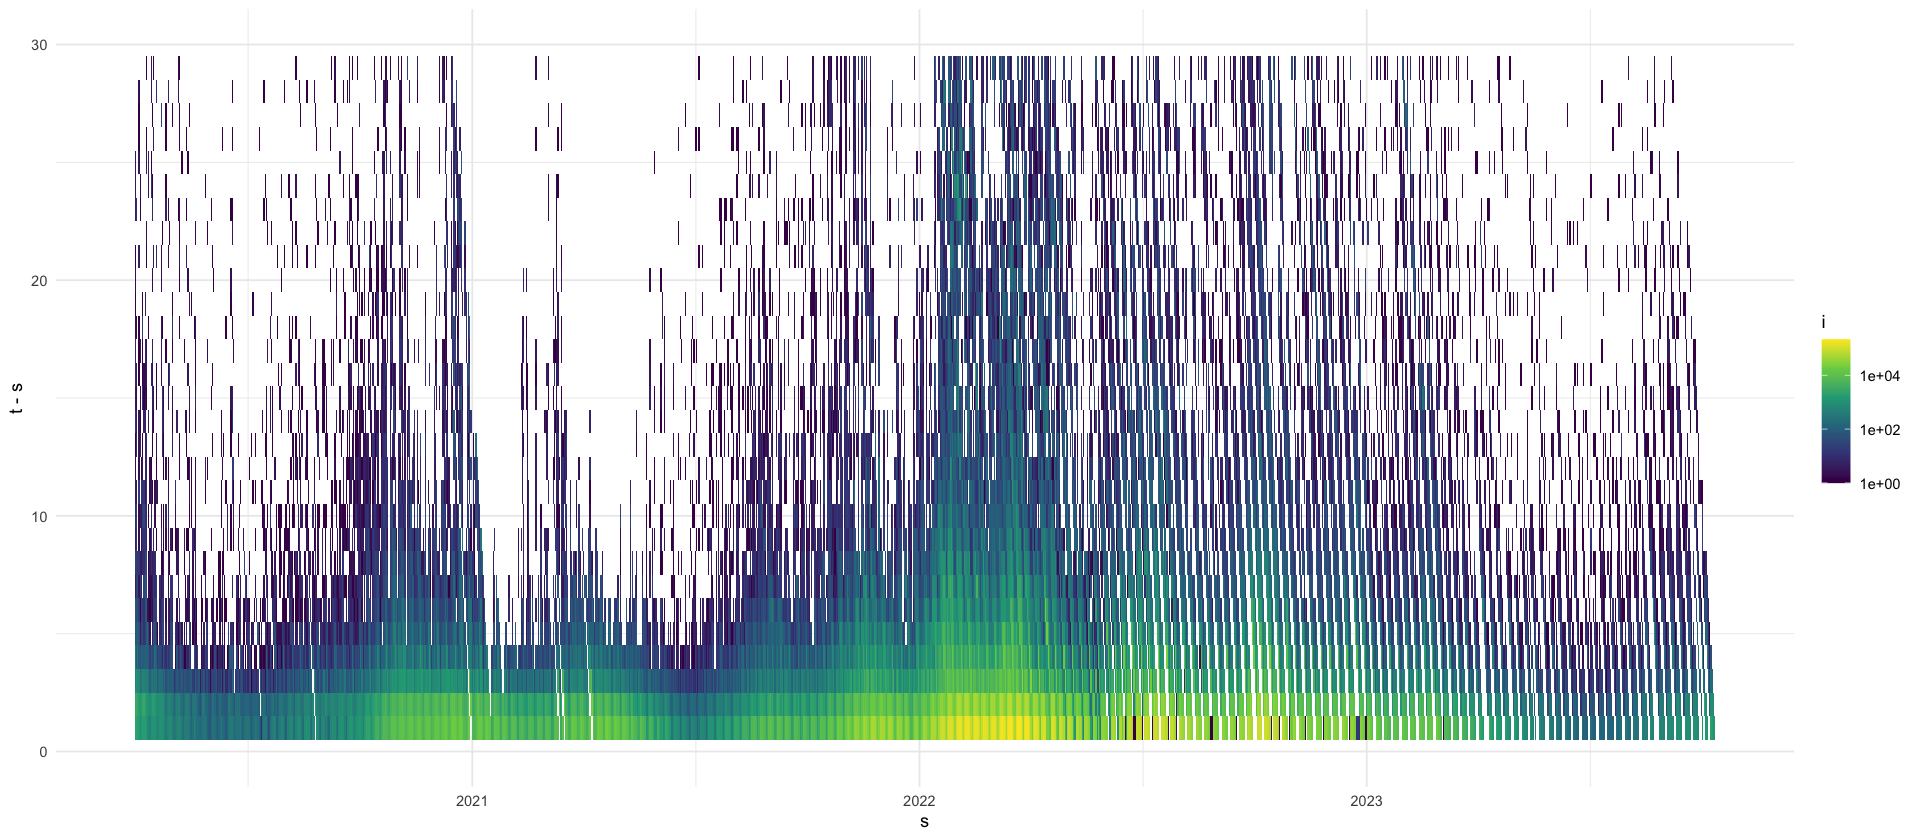

In [9]:
rep_tri_cummax <- full_rep_tri %>%
    arrange(t) %>%
    group_by(s) %>%
    mutate(
        I_tilde = pmin(cummax(I), tail(I, 1)),
    ) %>%
    ungroup()

increments <- rep_tri_cummax %>%
    group_by(s) %>%
    mutate(
        i = I_tilde - lag(I_tilde, default = 0),
    ) %>%
    ungroup()

stopifnot(all(increments$i >= 0))

increments %>%
    ggplot(aes(x = s, y = t - s, fill = i)) +
    geom_tile() +
    scale_fill_viridis_c(trans = "log10", na.value = rgb(0, 0, 0, 0)) +
    ylim(0, 30)


max_tau <- 4
increments %>%
    mutate(tau = as.numeric(t - s)) %>%
    filter(tau <= max_tau) %>%
    filter(s >= min(s) + max_tau) %>%
    select(s, tau, i) %>%
    pivot_wider(names_from = tau, values_from = i, values_fill = 0) %>%
    rename(county_date = s) %>%
    write_csv(here("data/processed/RKI_4day_rt.csv"))


We see that most delays are short. Let us investigate the proportion of reported cases with delay $\tau = t - s$:

$$
    p_{\tau} = \frac{\sum_{t - s = \tau} i_{s, t}}{\sum_{t,s} i_{s,t}}
$$

and we will look at the survival function 
$$
    \hat S(\tau) =  1- \sum_{\tau' \leq \tau} p_{\tau'}
$$
which measures the fraction of cases reported after $\tau$ days of delay.

### `tikz/survival_function_rep_tri_incidences.tex`

Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ord_fct = fct_relevel(ord_fct, paste0(year(ord_fct), "-Q",
  quarter(ord_fct)))`.
Caused by warning:
! tz(): Don't know how to compute timezone for object of class ordered/factor; returning "UTC".
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”
Warning message in scale_y_log10(breaks = c(0.1, 0.01, 0.001), labels = c("0.1", :
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(breaks = c(0.1, 0.01, 0.001), labels = c("0.1", :
“log-10 transformation introduced infinite values.”


pdf 
  2

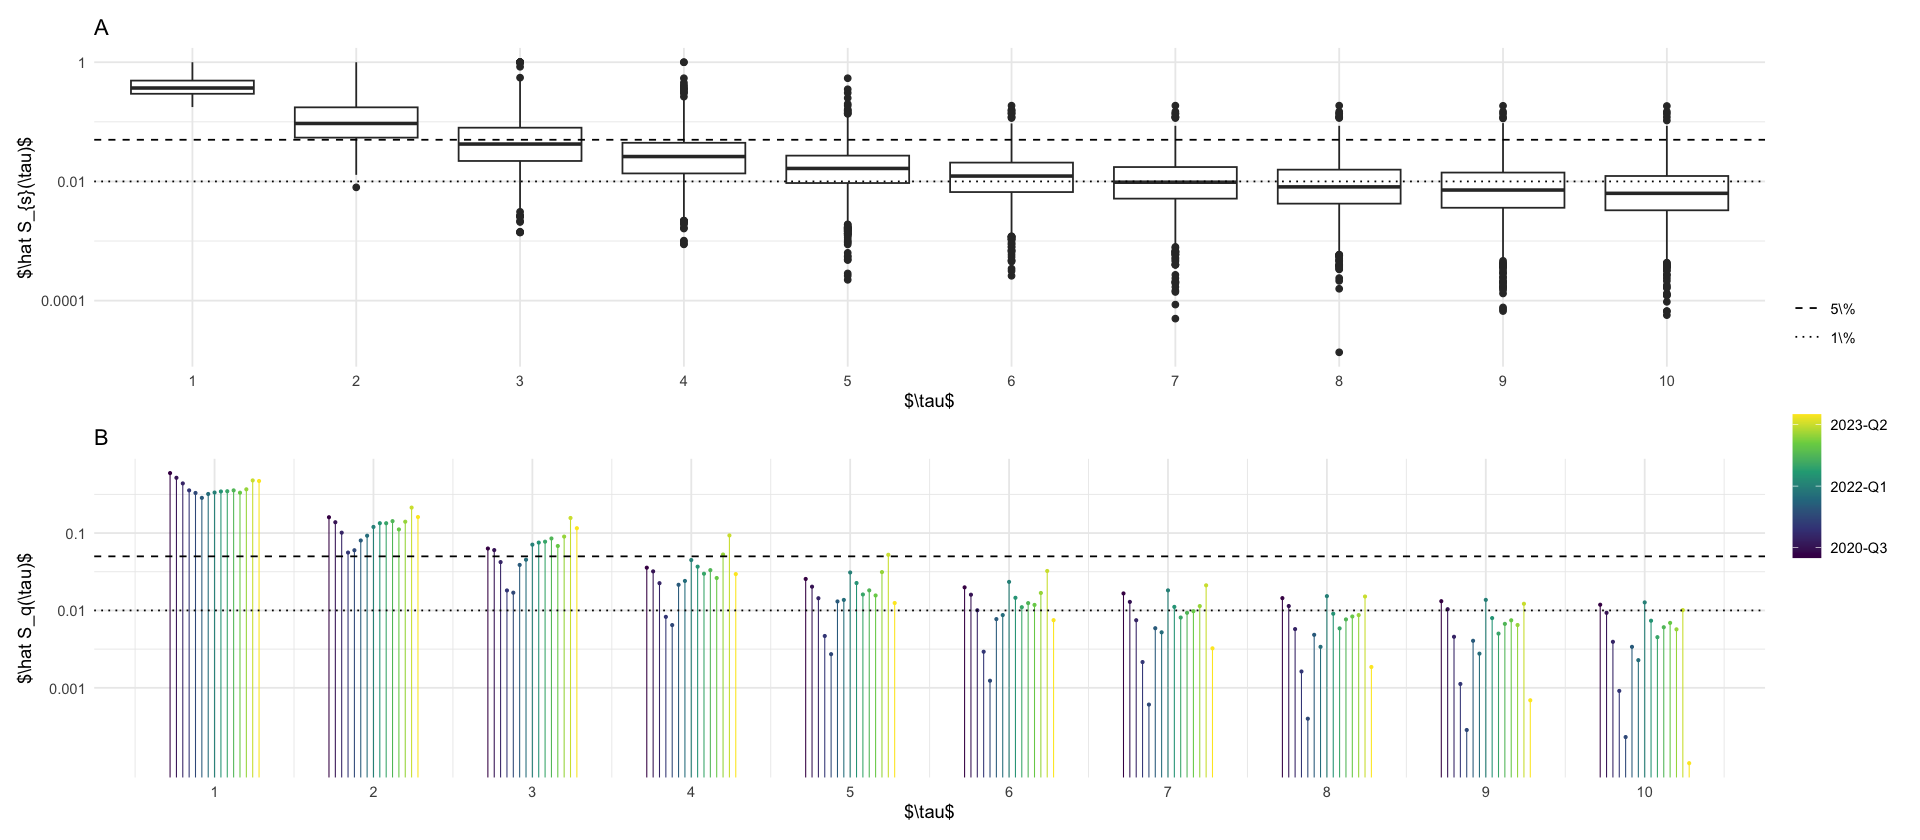

In [10]:
total_S <- increments %>%
    mutate(tau = as.numeric(t - s)) %>%
    group_by(tau) %>%
    summarize(total = sum(i)) %>%
    ungroup() %>%
    mutate(p = total / sum(total)) %>%
    mutate(S = 1 - cumsum(p))

quarter_S <- increments %>%
    mutate(tau = as.numeric(t - s)) %>%
    group_by(quarter = floor_date(s, "quarter"), tau) %>%
    summarize(total = sum(i)) %>%
    mutate(p = total / sum(total)) %>%
    mutate(S = 1 - cumsum(p)) %>%
    ungroup()
p_boxplots <- increments %>%
    mutate(tau = as.numeric(t - s)) %>%
    group_by(s) %>%
    arrange(t) %>%
    mutate(p = i / sum(i)) %>%
    mutate(S = 1 - cumsum(p)) %>%
    ungroup() %>%
    filter(tau <= 10) %>%
    filter(S > 1e-7) %>%
    ggplot(aes(x = factor(tau), y = S, group = tau)) +
    geom_boxplot() +
    scale_y_log10(breaks = c(1, .01, .0001), labels = c("1", "0.01", "0.0001")) +
    geom_hline(aes(yintercept = y, linetype = name), data = tibble(y = c(.05, .01), name = factor(2:3, labels = c("5\\%", "1\\%")))) +
    scale_linetype_manual(values = c("dashed", "dotted")) +
    labs(x = "$\\tau$", y = "$\\hat S_{s}(\\tau)$", title = "A", linetype = "")

p_hat_S <- quarter_S %>%
    filter(tau <= 10) %>%
    # mutate(label = ifelse(tau %in% c(4,8), paste(round(S * 100, 1), "\\%") , NA)) %>%
    mutate(ord_fct = ordered(quarter)) %>%
    # relevel ord_fct to use levels(fct) <- paste0(year(fct), "-Q", quarter(fct))
    mutate(ord_fct = fct_relevel(ord_fct, paste0(year(ord_fct), "-Q", quarter(ord_fct)))) %>%
    mutate(group = as.numeric(ord_fct)) %>%
    mutate(x = tau + (group - 8) / 25) %>%
    ggplot(aes(x = x, y = S, color = group)) +
    geom_point(size = .5) +
    geom_segment(aes(x = x, xend = x, y = S, yend = 0), linewidth = .3) +
    geom_hline(aes(yintercept = y, linetype = name), data = tibble(y = c(.05, .01), name = factor(2:3, labels = c("5\\%", "1\\%")))) +
    scale_linetype_manual(values = c("dashed", "dotted")) +
    scale_x_continuous(breaks = 0:10) +
    scale_y_log10(breaks = c(.1, .01, .001), labels = c("0.1", "0.01", "0.001")) +
    labs(x = "$\\tau$", y = "$\\hat S_q(\\tau)$", color = "", linetype = "", title = "B") +
    scale_color_viridis_c(breaks = c(2, 8, 14), labels = c("2020-Q3", "2022-Q1", "2023-Q2")) +
    guides(color = guide_colorbar())

p_boxplots / p_hat_S + plot_layout(heights = c(1, 1), guides = "collect")

ggsave_tikz(here("tikz/survival_function_rep_tri_incidences.tex"))


## RKI Hospitalization data

Denote by 
$$
    H^{a}_{s,t}
$$
the number of hospitalisations in age-group $a$ whose case reporting date is $s$ and whose hospitalization reporting date is $t$.


In [11]:
hospitalisations_raw <- read_csv(here("data/raw/all_hosp_age.csv")) %>%
    select(-location) %>%
    rename(a = age_group, s = case_date, t = hosp_date, H = value)


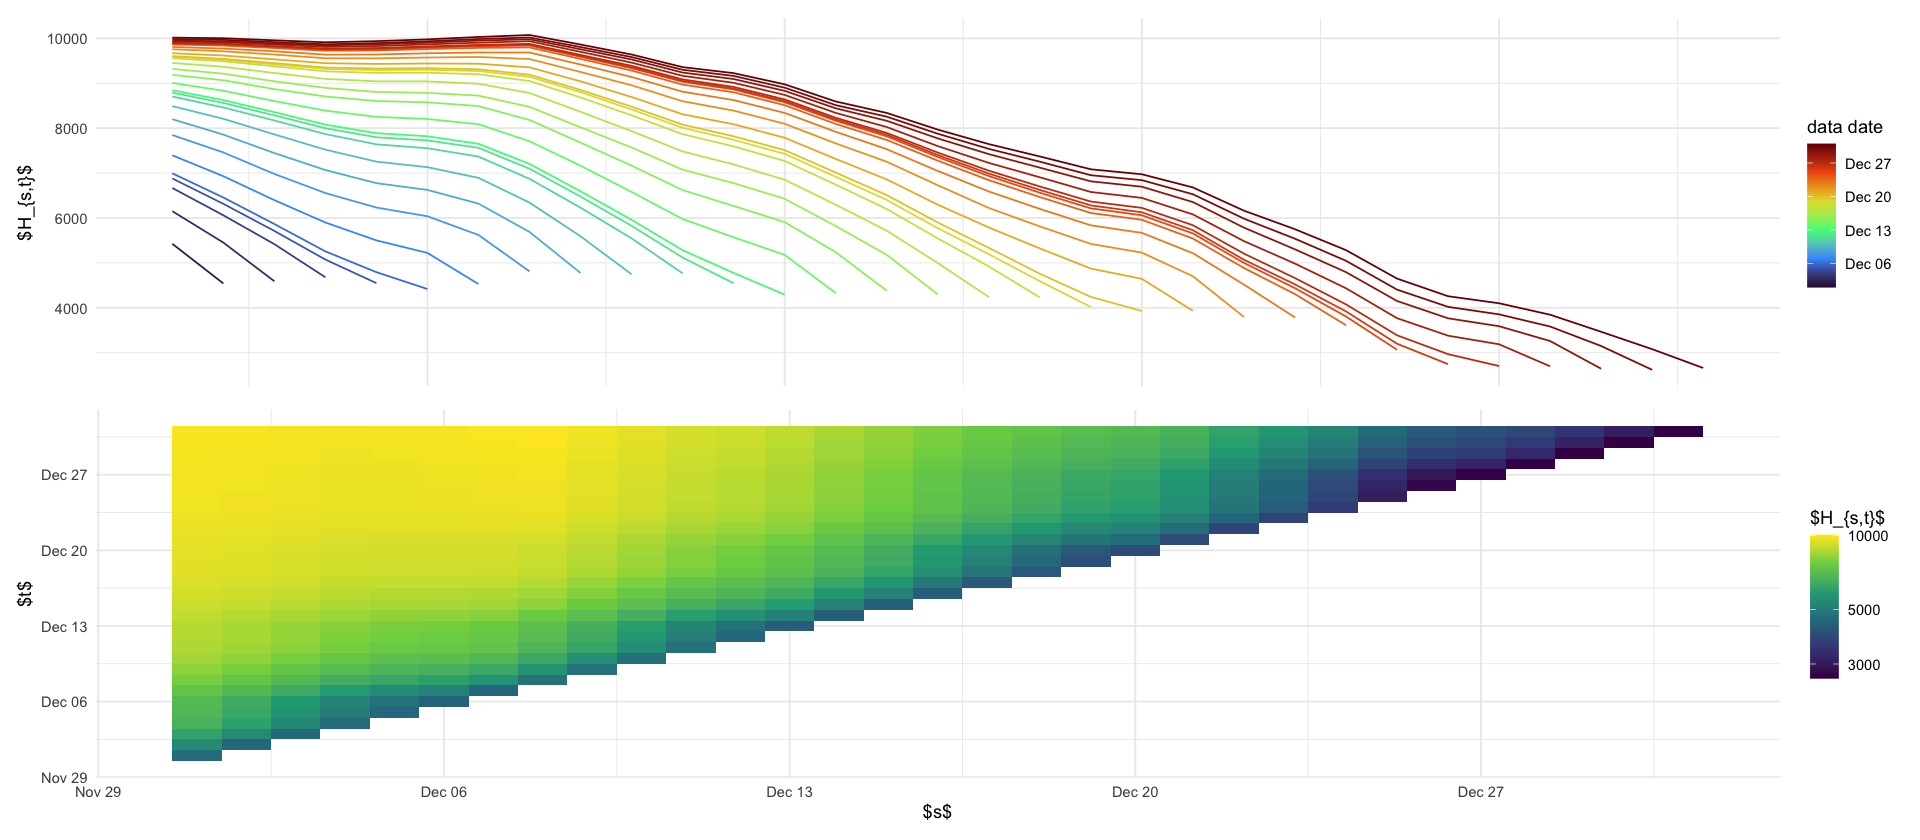

In [12]:
df_hosp_plot <- hospitalisations_raw %>%
    filter(s >= ymd("2021-12-01"), s < ymd("2022-01-01")) %>%
    filter(t >= ymd("2021-12-01"), t < ymd("2022-01-01")) %>%
    group_by(s, t) %>%
    summarize(H = sum(H))

p_reptri_hosp <- df_hosp_plot %>%
    ggplot(aes(s, t, fill = H)) +
    geom_tile() +
    scale_fill_viridis_c(trans = "log10") +
    labs(fill = "$H_{s,t}$", x = "$s$", y = "$t$")

p_marginal_hosp <- df_hosp_plot %>%
    ggplot(aes(s, H, color = t, group = t)) +
    geom_line() +
    theme(axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank()) +
    labs(x = "", y = "$H_{s,t}$", color = "data date") +
    scale_color_viridis_c(option = "H", trans = "date")

p_marginal_hosp / p_reptri_hosp


pdf 
  2

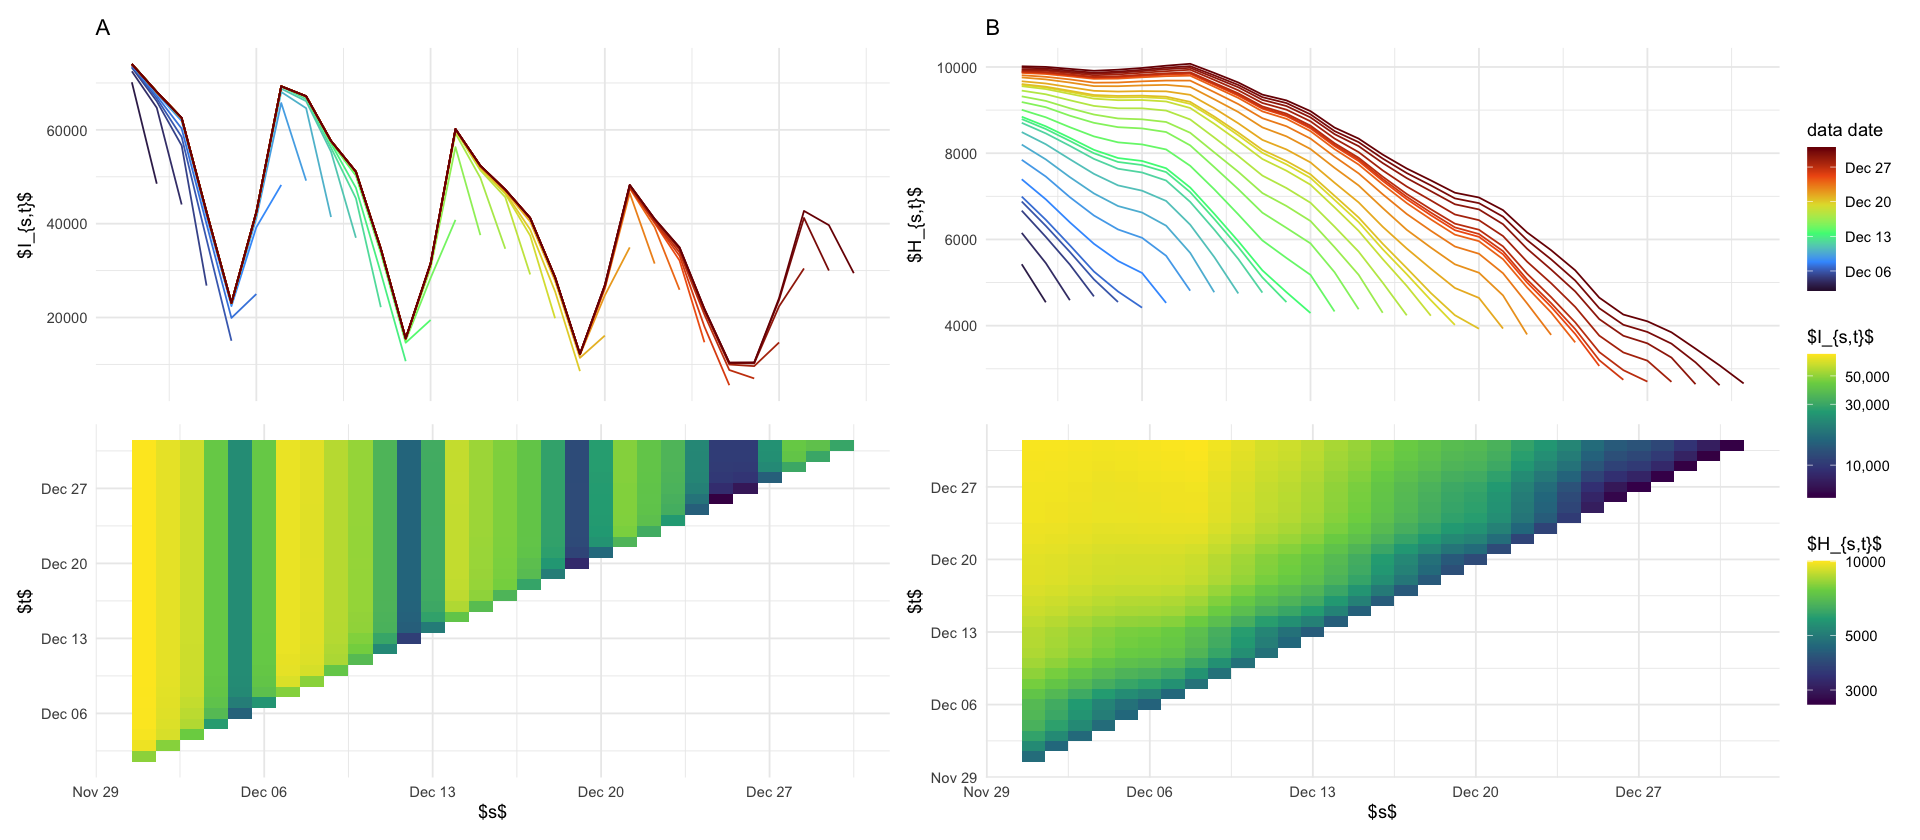

In [13]:
(((p_maginal_case + ggtitle("A")) / p_reptri_case) | ((p_marginal_hosp + ggtitle("B")) / p_reptri_hosp)) + plot_layout(heights = c(1, 2), guides = "collect")

ggsave_tikz(here("tikz/reporting_delays_cases.tex"))


In [14]:
rep_tri_hosp_cummax <- hospitalisations_raw %>%
    arrange(t) %>%
    group_by(s, a) %>%
    mutate(
        H_tilde = pmin(cummax(H), tail(H, 1)),
        h = H_tilde - lag(H_tilde, default = 0),
    ) %>%
    ungroup() %>%
    mutate(tau = t - s)


Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message in scale_fill_viridis_c(trans = "log10", na.value = "grey80"):
“log-10 transformation introduced infinite values.”
Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message in scale_fill_viridis_c(trans = "log10", na.value = "grey80"):
“log-10 transformation introduced infinite values.”
Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.


pdf 
  2

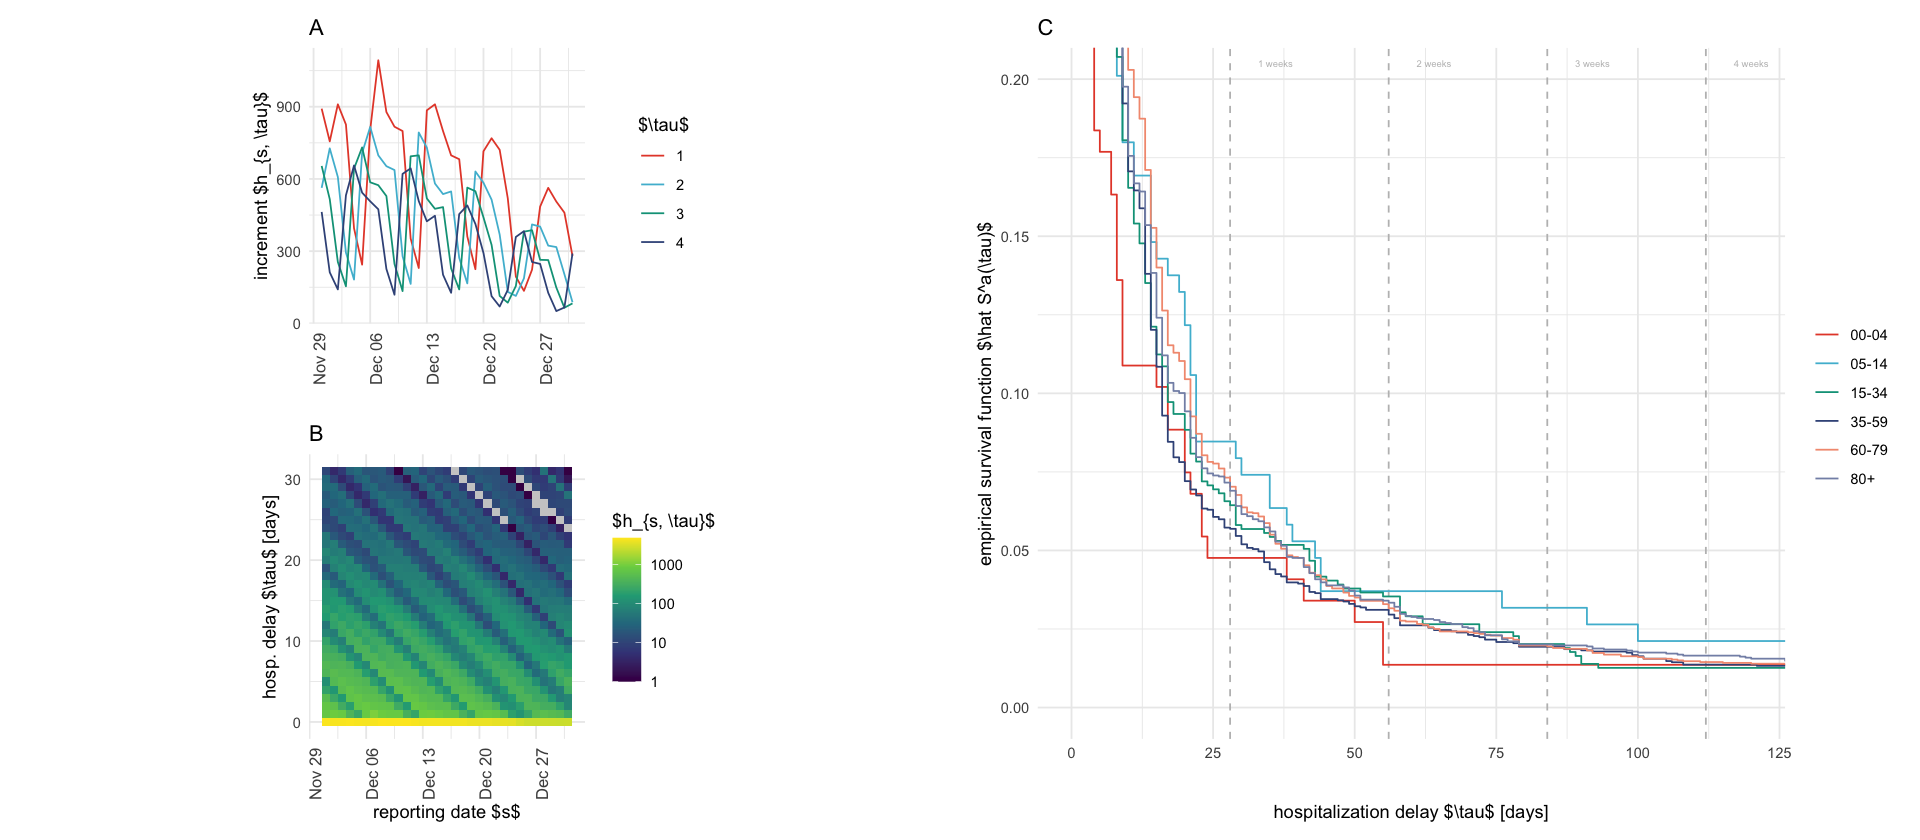

In [29]:
p_s_plus_tau_constant <- rep_tri_hosp_cummax %>%
    filter(tau <= 31) %>%
    filter(s >= ymd("2021-12-01")) %>%
    filter(s < ymd("2022-01-01")) %>%
    group_by(s, tau) %>%
    summarize(h = sum(h)) %>%
    ggplot(aes(s, tau, fill = h)) +
    geom_tile() +
    # facet_wrap(~a) +
    scale_fill_viridis_c(trans = "log10", na.value = "grey80") +
    coord_fixed() +
    labs(title = "B", x = "reporting date $s$", y = "hosp. delay $\\tau$ [days]", fill = "$h_{s, \\tau}$") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 10))

p_delayed_reporting_double <- rep_tri_hosp_cummax %>%
    filter(tau > 0, tau < 5) %>%
    filter(s >= ymd("2021-11-30")) %>%
    filter(s < ymd("2022-01-01")) %>%
    group_by(s, tau) %>%
    summarize(h = sum(h)) %>%
    mutate(tau = factor(tau)) %>%
    ggplot(aes(s, y = h, color = tau, group = tau)) +
    geom_line() +
    labs(color = "$\\tau$", x = "", y = "increment $h_{s, \\tau}$", title = "A") +
    # theme(axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank())
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 10))

p_survival <- rep_tri_hosp_cummax %>%
    filter(s == ymd("2021-12-01")) %>%
    group_by(a) %>%
    mutate(cum_p = cumsum(h) / sum(h)) %>%
    ungroup() %>%
    ggplot(aes(tau, 1 - cum_p, color = a)) +
    geom_vline(xintercept = 28 * seq(4), linetype = 2, color = "gray") +
    geom_step() +
    coord_cartesian(xlim = c(NA, 120), ylim = c(0, .2)) +
    labs(x = "hospitalization delay $\\tau$ [days]", y = "empirical survival function $\\hat S^a(\\tau)$", title = "C") +
    scale_color_discrete(name = "") + # ) +labels = as_labeller(age_group_labels)) +
    annotate("text", x = 28 * seq(4) + 8, y = .205, label = paste0(seq(4), " weeks"), size = 2, color = "gray")

((p_delayed_reporting_double / p_s_plus_tau_constant)) | p_survival

ggsave_tikz(here("tikz/double_weekday_effect_hosp.tex"))


## Tests


In [16]:
# add leading zeros to week, i.e. W2-1 -> W02-1
str_replace("2021-W2-1", "W([0-9])-", "W0\\1-")


[1] "2021-W02-1"

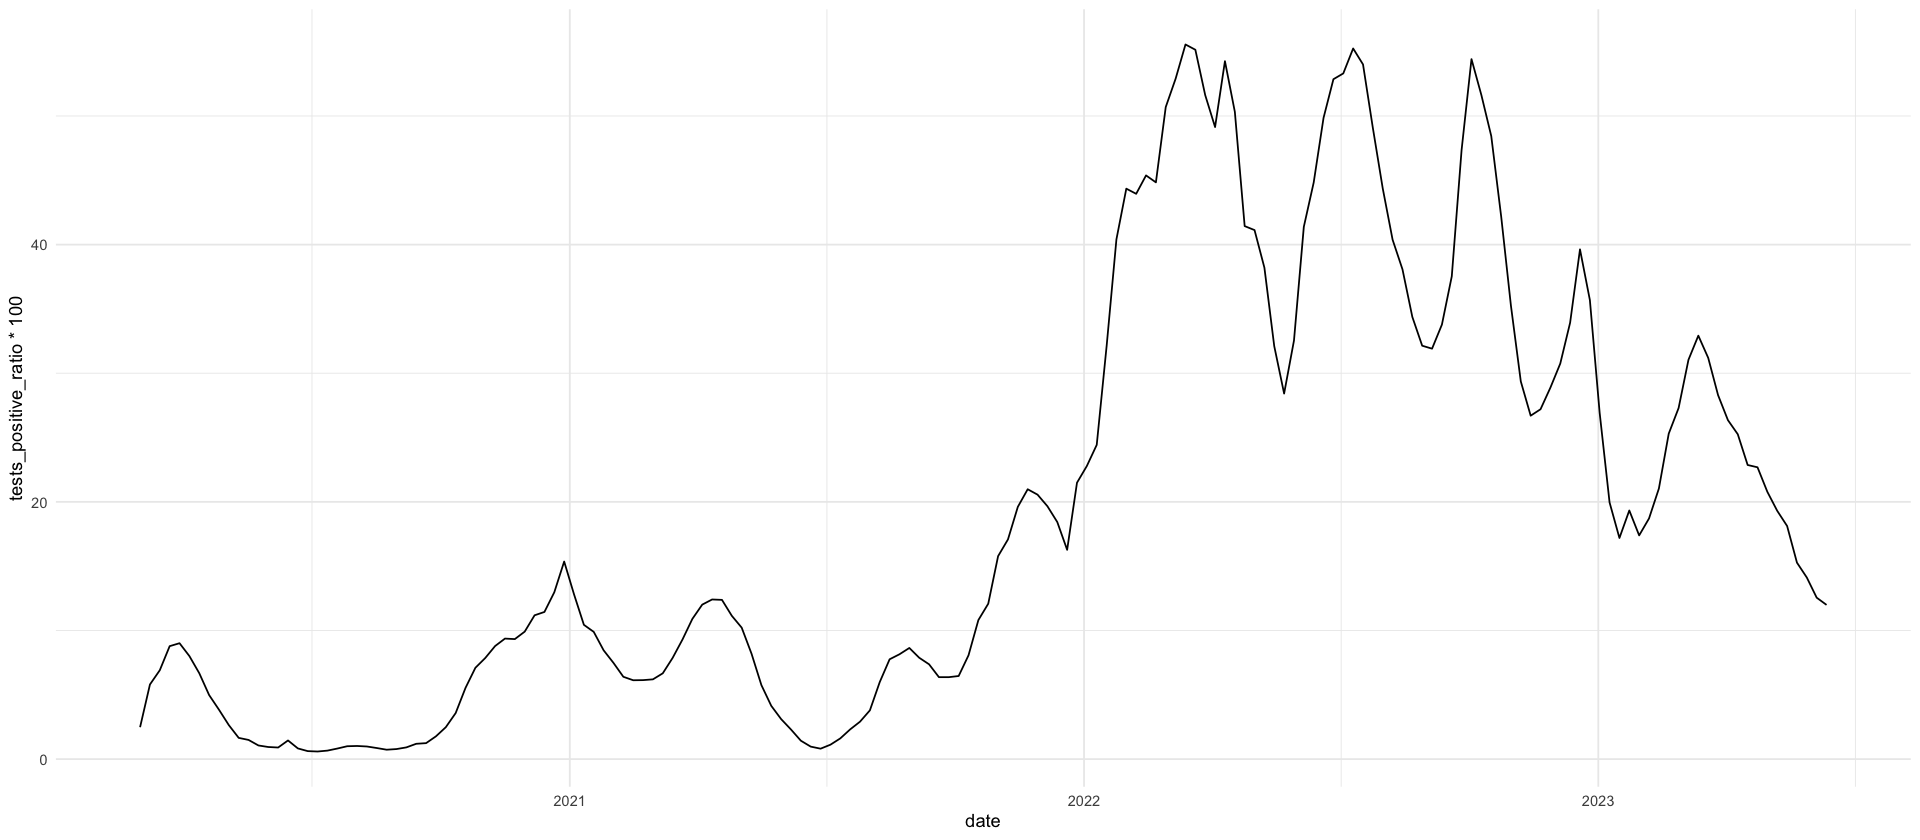

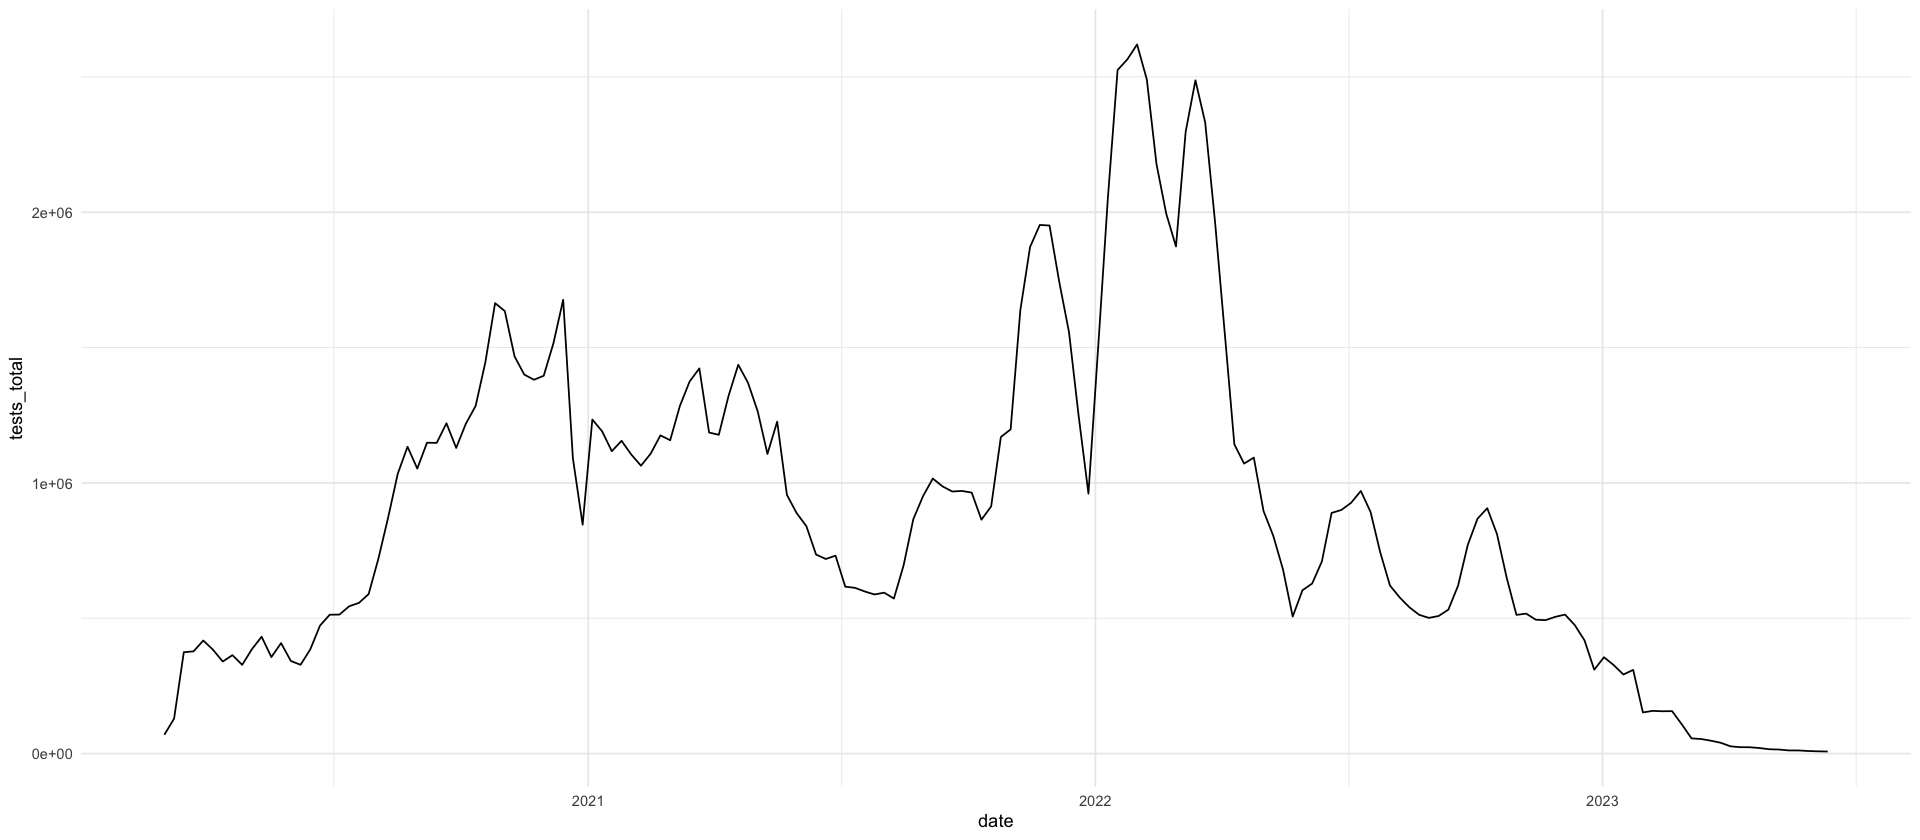

In [17]:
library(ISOweek)
tests <- read_csv("https://github.com/robert-koch-institut/SARS-CoV-2-PCR-Testungen_in_Deutschland/raw/main/SARS-CoV-2-PCR-Testungen_in_Deutschland.csv")

tests %>%
    mutate(date = paste0(date, "-1")) %>%
    mutate(date = str_replace(date, "W([0-9])-", "W0\\1-")) %>%
    mutate(date = ISOweek2date(date)) %>%
    ggplot(aes(date, tests_positive_ratio * 100)) +
    geom_line()

tests %>%
    mutate(date = paste0(date, "-1")) %>%
    mutate(date = str_replace(date, "W([0-9])-", "W0\\1-")) %>%
    mutate(date = ISOweek2date(date)) %>%
    ggplot(aes(date, tests_total)) +
    geom_line()


## Generation time distribution used

pdf 
  2

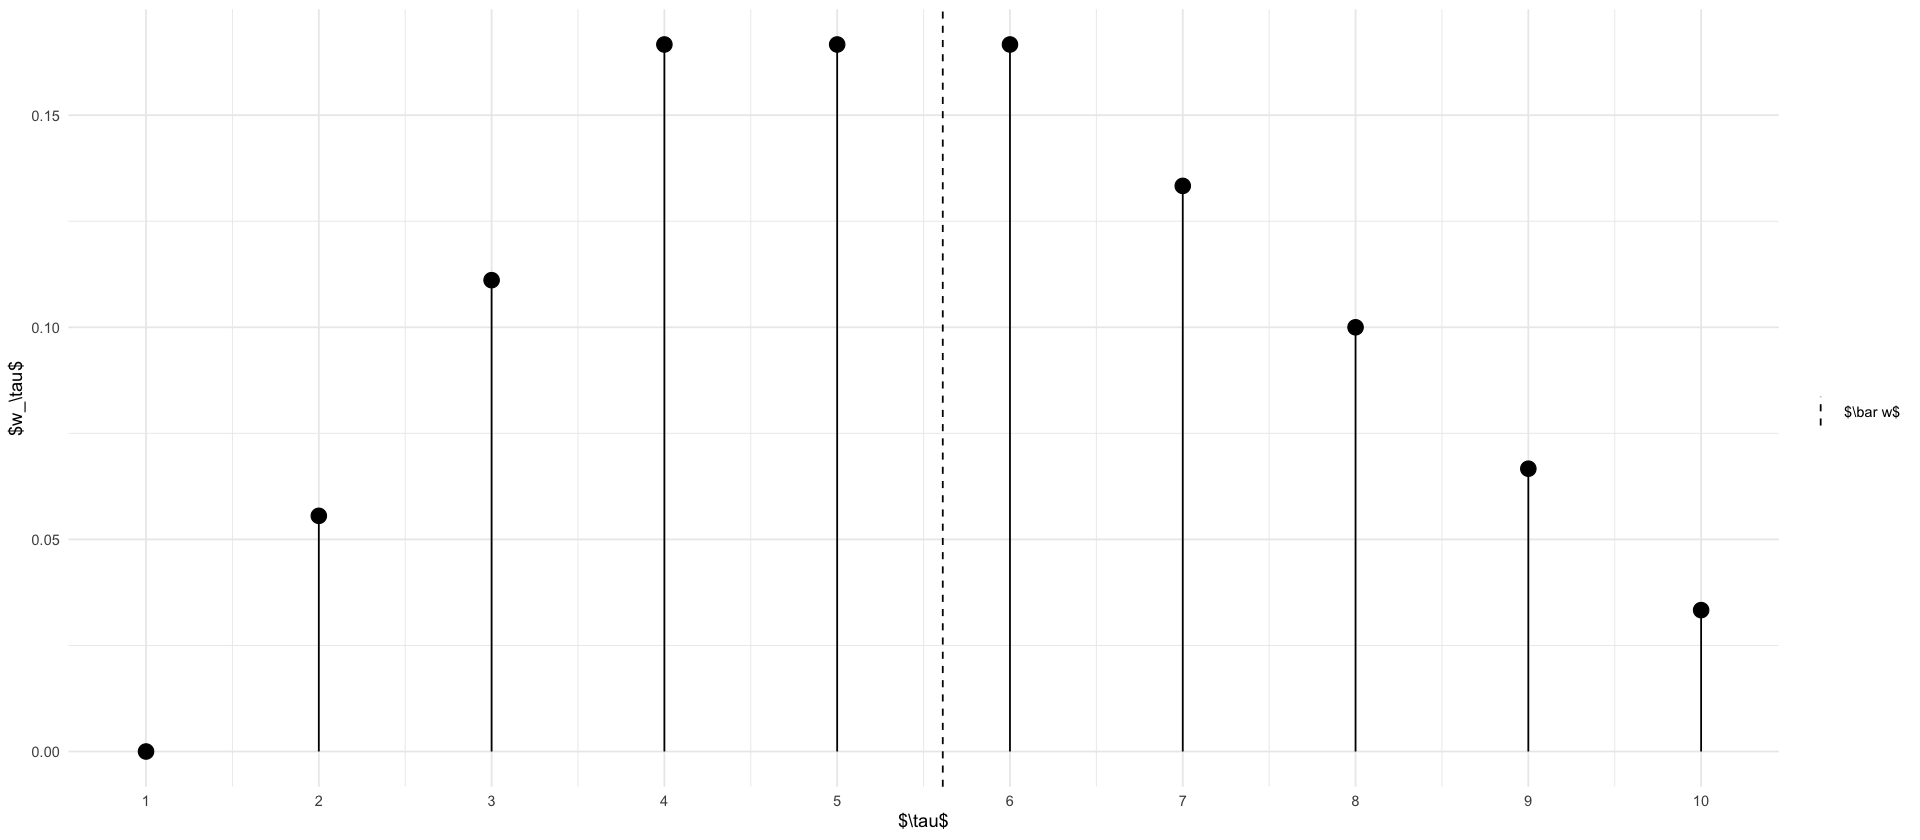

In [18]:
w <- c((0:3) / 3, 1, (5:1) / 5)
w <- w / sum(w)

mean_w <- sum(seq_along(w) * w)

tibble(tau = seq_along(w), w = w) %>%
    ggplot(aes(tau, w)) +
    geom_point(size = 4) +
    geom_segment(aes(xend = tau, yend = 0)) +
    geom_vline(data = tibble(mean = mean_w), mapping = aes(xintercept = mean, linetype = "$\\bar w$")) +
    scale_x_continuous(breaks = 0:length(w)) +
    scale_linetype_manual(values = "dashed") +
    labs(x = "$\\tau$", y = "$w_\\tau$", linetype = "")

ggsave_tikz(here("tikz/generation_time.tex"), height = 3)
write_csv(tibble(tau = seq_along(w), w = w), here("data/processed/generation_time.csv"))
